<a name="toc"></a>
# Table of contents
1. [Munge data to prepare for Doc2vec model](#introduction)
2. [Text normalization for Gensim Doc2Vec model](#paragraph1)
3. [Train Gensim Doc2Vec model](#paragraph2)
4. [Apply Spectral Embedding to find low-dimensional manifold](#paragraph3)
5. [Use Kmeans on Spectral Embedding to Produce Clusters](#paragraph4)
6. [PageRank over the citation/author network of papers](#paragraph5)
    1. [Generate network json](#paragraph5a)
    2. [Make list of edges over citation network](#paragraph5b)
    3. [PageRank using GraphFrames package](#paragraph5c)
7. [Classify papers by disease studied using named-entity recognition](#paragraph6)
8. [Clean data for Dashboarding](#paragraph8)

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import gensim
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from string import punctuation
import json
import networkx as nx
data_dir = 'D:\datasets\covid'

import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import SpectralEmbedding
seaborn.set_style("whitegrid")

<a name="introduction"></a>
[Top](#toc)
## 1. Munge data to prepare for Doc2vec model
1. Add year and first author rows for each paper
2. Merge <(author, year) title> to make unique paper ids
3. Remove empty or uninformative samples

In [186]:
data = pd.read_csv(os.path.join(data_dir, 'covid_data', 'metadata.csv'))

data['year'] = data['publish_time'].str.extract(r'^(\d{4})[\s,-]')
data['first_author'] = data['authors'].str.extract(r'^([\w-]+)[,$]')

data = data.dropna(subset = ['first_author', 'year', 'abstract'])

data['id'] = '(' + data['first_author'] + ',' + data['year'] + ') ' + data['title']
data = data.set_index('id')

data

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,year,first_author
id,,,,,,,,,,,,,,,,,
"(Overall,1972) Intrauterine virus infections and congenital heart disease",NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535.0,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,custom_license,1972,Overall
"(Brunner,1973) Clinical and immunologic studies in identical twins discordant for systemic lupus erythematosus",aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077.0,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,custom_license,1973,Brunner
"(Garibaldi,1985) Epidemiology of community-acquired respiratory tract infections in adults Incidence, etiology, and impact",NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285.0,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,custom_license,1985,Garibaldi
"(Cantey,1985) Infectious diarrhea: Pathogenesis and risk factors",212e990b378e8d267042753d5f9d4a64ea5e9869,Elsevier,Infectious diarrhea: Pathogenesis and risk fac...,10.1016/0002-9343(85)90367-5,NaN,2861742.0,els-covid,Abstract Our understanding of the pathogenesis...,1985-06-28,"Cantey, J.Robert",The American Journal of Medicine,NaN,NaN,True,custom_license,1985,Cantey
"(Zvaifler,1988) New perspectives on the pathogenesis of rheumatoid arthritis",bf5d344243153d58be692ceb26f52c08e2bd2d2f,Elsevier,New perspectives on the pathogenesis of rheuma...,10.1016/0002-9343(88)90356-7,NaN,3052052.0,els-covid,Abstract In the pathogenesis of rheumatoid art...,1988-10-14,"Zvaifler, Nathan J.",The American Journal of Medicine,NaN,NaN,True,custom_license,1988,Zvaifler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(Brini,2017) Epidemiology and clinical profile of pathogens responsible for the hospitalization of children in Sousse area, Tunisia",d4f00f66c732c292fcfc28b19f44daa2fa620901,PMC,Epidemiology and clinical profile of pathogens...,10.1371/journal.pone.0188325,PMC5693464,29149199.0,cc-by,This study aimed to identify a broad spectrum ...,2017 Nov 17,"Brini, Ines; Guerrero, Aida; Hannachi, Naila; ...",PLoS One,NaN,NaN,True,comm_use_subset,2017,Brini
"(Bissonnette,2009) Functional Analysis of the Transmembrane Domain in Paramyxovirus F Protein-Mediated Membrane Fusion",ec575d33c0d3b34af7644fcfed64af045a75ab63,Elsevier,Functional Analysis of the Transmembrane Domai...,10.1016/j.jmb.2008.12.029,PMC2750892,19121325.0,els-covid,"Abstract To enter cells, enveloped viruses use...",2009-02-13,"Bissonnette, Mei Lin Z.; Donald, Jason E.; DeG...",Journal of Molecular Biology,NaN,NaN,True,custom_license,2009,Bissonnette
"(Iketani,2018) Viral Entry Properties Required for Fitness in Humans Are Lost through Rapid Genomic Change during Viral Isolation",7f8715a818bfd325bf4413d3c07003d7ce7b6f7e,PMC,Viral Entry Properties Required for Fitness in...,10.1128/mBio.00898-18,PMC6030562,29970463.0,cc-by,Human parainfluenza viruses cause a large burd...,2018 Jul 3,"Iketani, Sho; Shean, Ryan C.; Ferren, Marion; ...",mBio,NaN,NaN,True,comm_use_subset,2018,Iketani


In [4]:
abstracts = data['abstract'].to_frame()
abstracts = abstracts[(abstracts.abstract != 'Unknown') & (abstracts.abstract != 'Abstract')]
abstracts['len'] = abstracts['abstract'].str.len()
abstracts = abstracts.sort_values('len')
abstracts = abstracts[abstracts['len'] > 5]
abstracts

,abstract,len
id,,
"(Robotis,2007) Viral Hepatitis",While …,7
"(Applegate,2020) COVID-19 Presents High Risk to Older Persons",Not Avail.,10
"(Ziebuhr,2003) SARS – Unprecedented global response to a newly emerging disease",Abstract No Abstract,20
"(Enos,2020) To ease anxiety over coronavirus, leaders prescribe dose of common sense",Wash hands thoroughly.,22
"(Posey,2004) Manual of Travel Medicine and Health",Manual of Travel Medicine and Health,36
...,...,...
"(Kupferschmidt,2020) Will novel virus go pandemic or be contained?",The repatriation of 565 Japanese citizens from...,8978
"(Science,2020) China virus response criticized as slow",As the novel coronavirus that emerged in Wuhan...,12781
"(Niculae,2016) The 12th Edition of the Scientific Days of the National Institute for Infectious Diseases “Prof. Dr. Matei Bals” and the 12th National Infectious Diseases Conference: Bucharest, Romania. 23–25 November 2016",A1 The outcome of patients with recurrent vers...,27345


<a name="paragraph1"></a>
[Top](#toc)
## 2. Text normalization for Gensim Doc2Vec model
1. Filter again for uninformative data
2. Tokenize abstracts into sentences, then words
3. Lowercase only the first letter in each sentence *if and only if* that word is not fully uppercase. This prevents over-normalization of proper nouns or accronyms which are common in biological text.

##### Normalization example:
BRCA1 is an important tumor suppressor. -> [BRCA1, is, an, important, tumor, suppressor]<br>
This experiment tests BRCA1 tumor suppressing ability. -> [this, experiment, tests, BRCA1, tumor ...]

In [5]:
class BadDataException(Exception):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

def load_and_normalize(doc_str):
    if doc_str == "Unknown":
        raise BadDataException()
    if doc_str[0] == '"':
        doc_str = doc_str[1:-2]
    if doc_str[:8] == 'Abstract':
        doc_str = doc_str[8:]
    words = [ 
        word if word.isupper() or i > 0 else word.lower()
        for sent in sent_tokenize(doc_str) for i, word in enumerate(word_tokenize(sent))
        if word not in punctuation
    ]
    if len(words) < 1:
        raise BadDataException(words, doc_str)
    return words

In [6]:
tagged_docs = [
    gensim.models.doc2vec.TaggedDocument(load_and_normalize(text), [tag])
    for tag, text in abstracts['abstract'].items()
]

len(tagged_docs)

24434

<a name="paragraph2"></a>
[Top](#toc)
## 3. Train Gensim Doc2Vec model
1. Generate samples from each abstract using the normalization procedure outlined above.
2. Train the Doc2Vec model to produce embedding vectors for each abstract in the corpus
3. Validate the Doc2Vec model by computing new vectors for each abstract in the corpus, then finding the most similar embedding vector produced during training of the model. The most similar vector to each abstract should be itself.

In [132]:
tagged_docs[100]

TaggedDocument(words=['just', 'as', 'proteins', 'form', 'distinct', 'structural', 'motifs', 'certain', 'structures', 'are', 'commonly', 'adopted', 'by', 'RNA', 'molecules', 'amongst', 'the', 'most', 'prevalent', 'is', 'the', 'RNA', 'pseudoknot'], tags=['(Staple,2005) Pseudoknots: RNA Structures with Diverse Functions'])

In [134]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=5, epochs=40)
model.build_vocab(tagged_docs)

model.wv.vocab

model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)

model.save(os.path.join(data_dir, 'd2v_model'))

{'while': <gensim.models.keyedvectors.Vocab at 0x23d817cf6d8>,
 '…': <gensim.models.keyedvectors.Vocab at 0x23db621f908>,
 'not': <gensim.models.keyedvectors.Vocab at 0x23dd5252358>,
 'no': <gensim.models.keyedvectors.Vocab at 0x23dd5252390>,
 'Abstract': <gensim.models.keyedvectors.Vocab at 0x23dd5252438>,
 'wash': <gensim.models.keyedvectors.Vocab at 0x23dd52525c0>,
 'hands': <gensim.models.keyedvectors.Vocab at 0x23dd5252470>,
 'thoroughly': <gensim.models.keyedvectors.Vocab at 0x23dd5252630>,
 'manual': <gensim.models.keyedvectors.Vocab at 0x23dd5252668>,
 'of': <gensim.models.keyedvectors.Vocab at 0x23dd52526a0>,
 'Travel': <gensim.models.keyedvectors.Vocab at 0x23dd52526d8>,
 'Medicine': <gensim.models.keyedvectors.Vocab at 0x23dd5252710>,
 'and': <gensim.models.keyedvectors.Vocab at 0x23dd5252748>,
 'Health': <gensim.models.keyedvectors.Vocab at 0x23dd5252780>,
 'lt': <gensim.models.keyedvectors.Vocab at 0x23dd52527b8>,
 'No': <gensim.models.keyedvectors.Vocab at 0x23dd52527f0>,

In [46]:
model = gensim.models.doc2vec.Doc2Vec.load(os.path.join(data_dir, 'd2v_model'))

In [187]:
docvecs = [
    (tag, model.docvecs[tag])
    for tag, info in model.docvecs.doctags.items()
]

docvec_df = pd.DataFrame(docvecs, columns = ['id', 'docvec'])

docvec_df = docvec_df.set_index('id')

data = data.join(docvec_df, how = 'left')

data.to_csv(os.path.join(data_dir, 'metadata_d2v.csv'), header = True)

#### Valiate Doc2Vec model
Of all 24,436 abstracts tested, all but two were found to be most similar to its embedding produced by the model.

In [33]:
validation_results = [] #schema: doc_id, rank, similarity, abstract_len
for i in range(len(tagged_docs)):
    doc_id = tagged_docs[i].tags[0]
    similarities = model.docvecs.most_similar(
        [model.infer_vector(tagged_docs[i].words)],
        topn=3)
    found = False
    for r, (tag, sim) in enumerate(similarities):
        if tag == doc_id:
            validation_results.append((doc_id, str(rank), sim, len(tagged_docs[i].words)))
            found = True
            break
    if not found:
        validation_results.append((doc_id, "4+", 0))

In [34]:
validation_df = pd.DataFrame(validation_results, columns = ['id','rank','similarity','abstract_len'])

In [36]:
validation_df.groupby('rank').count()

,id,similarity,abstract_len
rank,,,
1,24432,24432,24432
4+,2,2,0


<a name="paragraph3"></a>
[Top](#toc)
## 4. Apply Spectral Embedding to find low-dimensional manifold
Spectral embedding transforms the adjacency matrix of a graph into a lower dimensional form. In this case, I will define the graph to be the cosine similarity matrix of the generated abstract embeddings, and I will embed that matrix in d=10 dimensional space. I will then use TSNE to visualize and Kmeans the cluster the resulting embeddings.

#run if resuming from file
data = pd.read_csv(os.path.join(data_dir, 'metadata_d2v.csv'))
data['docvec'] = data['docvec'].str.strip('[]').str.strip().str.split(r'\s+')
data = data.set_index('id')

In [48]:
docvecs = data['docvec'].dropna().to_frame()

doc_matrix = np.stack([*docvecs['docvec'].values]).astype(np.float32)
doc_matrix.shape

(24434, 300)

In [62]:
sim_matrix = cosine_similarity(doc_matrix)

spectral_embedding = SpectralEmbedding(n_components=10, affinity = "precomputed").fit_transform(sim_matrix)
spectral_embedding.shape

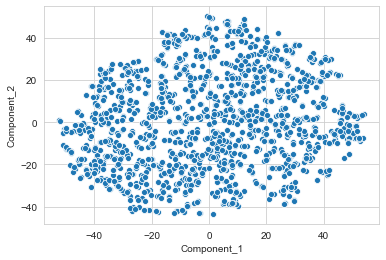

In [131]:
sub_sample = spectral_embedding[np.random.choice(spectral_embedding.shape[0], 1500, replace = False), :]
tsne_embedded = TSNE(2, learning_rate = 10, perplexity=10).fit_transform(sub_sample)
manifold_df = pd.DataFrame(tsne_embedded, columns = ['Component_1','Component_2'])
seaborn.scatterplot(data = manifold_df, x = 'Component_1', y = 'Component_2')

<a name="paragraph4"></a>
[Top](#toc)
# 5. Use Kmeans on Spectral Embedding to Produce Clusters

In [ ]:
labels = KMeans(10).fit_predict(spectral_embedding)

In [143]:
sil_score = silhouette_samples(spectral_embedding, labels)
cluster_results = pd.DataFrame({'label' : labels, 'score' : sil_score}, index = docvecs.index)

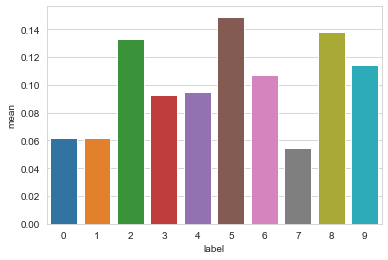

In [172]:
seaborn.barplot(data = cluster_results.groupby('label').agg(['mean','std'])['score'].reset_index(),
                x = 'label',y = 'mean',ci='std')

In [188]:
data = data.join(cluster_results['label'], how = 'left')
data.to_csv(os.path.join(data_dir, 'metdata_d2v_cluster.csv'))

Now try to evaluate each cluster to choose a label

In [161]:
data.dropna(subset = ['label', 'pagerank']).sort_values('pagerank')\
.groupby('label').head(25).sort_values(['label','pagerank']).set_index('label')['title'].to_frame()\
.to_csv(os.path.join(data_dir, 'category_analysis.csv'))

Category Labels:
0. Biochemistry, Non-traditional Medicine, and Nanotech
1. Therapy and Management
2. Virology and Infections
3. Public Transmission
4. SARS and COVID-19
5. Respiratory Infections, particularly influenza
6. Zoological Viruses
7. Genetics
8. Public Health, risks and planning
9. Therapuetics and Vaccination

In [164]:
categories_df = pd.DataFrame([
    (0, 'Biochemistry, Non-traditional Medicine, and Nanotech'),
    (1, 'Disease Therapy and Management'),
    (2, 'Virology and Infections'),
    (3, 'Public Transmission'),
    (4, 'SARS and COVID-19 Outbreaks'),
    (5, 'Respiratory Infections, particularly influenza'),
    (6, 'Zoological Viruses'),
    (7, 'Genetics and Metagenetic Analysis'),
    (8, 'Public Health, risks and planning'),
    (9, 'Therapuetics and Vaccination'),
], columns = ['label','category_description'])

In [167]:
data = data.merge(categories_df, on = 'label', how = 'left')
data.to_csv(os.path.join(data_dir, 'metadata_analysis_complete.csv'))

<a name="paragraph5"></a>
[Top](#toc)
# 6. PageRank over the citation/author network of papers

<a name="paragraph5a"></a>
1. Transform the long-form records into a more convenient schema for constructing the citation network.

In [ ]:
def get_name_id(author_metadata):
    try:
        first_initial = author_metadata['first'][0] 
    except (KeyError, IndexError):
        first_initial = ''
    middle_intitial = author_metadata['middle'][0] if len(author_metadata['middle']) > 0 else ''
    last = author_metadata['last'] or ''
    if len(first_initial + middle_intitial + last) == 0:
        return 'N.A'
    return '{}, {}{}'.format(last, first_initial, middle_intitial)

def get_paper_id(bib_metadata):
    year = str(bib_metadata['year']) if not bib_metadata['year'] is None else 'N.D.'
    title = bib_metadata['title'] or 'No Title'
    return "({}) {}".format(year, title)

def convert_json_to_network_data(json_str):
    schema = json.loads(json_str)
    output_schema = {
        'paper_id' : schema['paper_id'],
        'authors' : [
            get_name_id(author_metadata) for author_metadata in schema['metadata']['authors']
        ],
        'citations' : [
            {
                'paper' : get_paper_id(bib_metadata),
                'authors' : [
                    get_name_id(author_metadata) for author_metadata in bib_metadata['authors']
                ]
            }
            for (bibkey, bib_metadata) in schema['bib_entries'].items()
        ]
    }
    return output_schema

full_text_dirs = [
    'D:\\datasets\\covid\\covid_data\\noncomm_use_subset\\noncomm_use_subset',
    'D:\\datasets\\covid\\covid_data\\custom_license\\custom_license',
    'D:\\datasets\\covid\\covid_data\\comm_use_subset\\comm_use_subset',
    'D:\\datasets\\covid\\covid_data\\biorxiv_medrxiv\\biorxiv_medrxiv'
]
output_dir = 'D:\\datasets\\covid\\network_json_files'
conversion_errors = []
successes = 0
for archive_dir in full_text_dirs:
    for filename in os.listdir(os.path.join(archive_dir)):
        try:
            with open(os.path.join(archive_dir, filename), 'r') as f:
                paper_text = f.read()
            network_data = convert_json_to_network_data(paper_text)
            with open(os.path.join(output_dir, filename), 'w') as f:
                f.write(json.dumps(network_data, indent = 4))
            successes += 1
            
            #if successes > 5:
            #    break
            print('\rConversions: {}'.format(str(successes)), end = '')
        except Exception as err:
            print("\nError!")
            conversion_errors.append((err, filename))
            raise Exception

[Top](#toc)
<a name="paragraph5b"></a>
2. Generate the set of all links:<br>
```Author <-> Paper -> Cited Paper <-> Cited Author```

In [ ]:
network_list = []
network_dir = os.path.join(data_dir, 'network_json_files')
for filename in os.listdir(network_dir):
    with open(os.path.join(network_dir, filename), 'r') as f:
        network_list.append((filename[:-5],f.read()))

network_df = pd.DataFrame(network_list, columns = ['sha','json_str'])

data = pd.read_csv(os.path.join(data_dir, 'metdata_d2v_cluster.csv'))
data['docvec'] = data['docvec'].str.strip('[]').str.strip().str.split(r'\s+')
data['docvec'] = data['docvec'].apply(lambda x : np.array(x).astype(np.float32))

data = data.set_index('id')

In [51]:
network_df = network_df.merge(data.reset_index()[['id','sha']], on = 'sha', how = 'right')
network_df = network_df.dropna()
network_df.count()

sha         23292
json_str    22609
id          24668
dtype: int64

In [59]:
def extract_relationships(row):
    
    paper_id = row['id']
    json_str = row['json_str']
    
    schema = json.loads(json_str)
    connections = []
    for author in schema['authors']:
        connections.append((author, paper_id, 'author -> paper'))
        connections.append((paper_id, author, 'paper -> author'))
    for cited_paper in schema['citations']:
        cited_paper_id = cited_paper['paper']
        connections.append((paper_id, cited_paper_id, 'paper -> cited_paper'))
        for cited_author in cited_paper['authors']:
            connections.append((cited_paper_id, cited_author, 'paper -> author'))
            connections.append((cited_author, cited_paper_id, 'author -> paper'))
    return connections

example = network_df.iloc[0]
relationships = extract_relationships(example)

pd.DataFrame(relationships, columns = ['src','dest','relation'])

network_df['relationships'] = network_df.apply(lambda x : extract_relationships(x), axis = 1)

edges = pd.DataFrame(list(network_df['relationships'].explode().values), columns = ['src','dest','relationship'])

edges[['type1','type2']] = edges['relationship'].str.split(' -> ', expand = True)
edges

edges = edges.drop_duplicates()

edges.to_csv(os.path.join(data_dir, 'graph_edges.csv'))

nodes = edges[['src','type1']]
nodes = nodes.rename(columns = {'src':'node','type1' : 'type'})

nodes = nodes.append(edges[['dest','type2']].rename(
    columns = {'type2': 'type', 'dest':'node'}))
nodes['type'].replace('cited_paper', 'paper', inplace = True)
nodes = nodes.drop_duplicates()

nodes.to_csv(os.path.join(data_dir, 'graph_nodes.csv'))

,src,dest,relation
0,"Cornelissen, E","(Cornelissen,2007) Absence of surface expressi...",author -> paper
1,"(Cornelissen,2007) Absence of surface expressi...","Cornelissen, E",paper -> author
2,"Dewerchin, HL","(Cornelissen,2007) Absence of surface expressi...",author -> paper
3,"(Cornelissen,2007) Absence of surface expressi...","Dewerchin, HL",paper -> author
4,"Hamme, EVan","(Cornelissen,2007) Absence of surface expressi...",author -> paper
...,...,...,...
138,"(Cornelissen,2007) Absence of surface expressi...","(Weiss,1981) Pathogenesis of feline infectious...",paper -> cited_paper
139,"(Weiss,1981) Pathogenesis of feline infectious...","Weiss, RC",paper -> author
140,"Weiss, RC","(Weiss,1981) Pathogenesis of feline infectious...",author -> paper
141,"(Weiss,1981) Pathogenesis of feline infectious...","Scott, FW",paper -> author


[Top](#toc)
<a name="paragraph5c"></a>
3. Run PageRank on citation network using distributed graphframes implementation through Apache Spark

In [116]:
edges = pd.read_csv(os.path.join(data_dir, 'graph_edges.csv'))

nodes = pd.read_csv(os.path.join(data_dir, 'graph_nodes.csv'))

In [122]:
G = nx.DiGraph()

In [157]:
node_list = [
    (node[1]['node'], {'type' : node[1]['type']})
    for node in nodes.iterrows()
]
node_list[:5]

[('Cornelissen, E', {'type': 'author'}),
 ('(Cornelissen,2007) Absence of surface expression of feline infectious peritonitis virus (FIPV) antigens on infected cells isolated from cats with FIP',
  {'type': 'paper'}),
 ('Dewerchin, HL', {'type': 'author'}),
 ('Hamme, EVan', {'type': 'author'}),
 ('Nauwynck, HJ', {'type': 'author'})]

In [161]:
edge_list = [
    (edge[1]['src'], edge[1]['dest'], {'relationship' : edge[1]['relationship']})
    for edge in edges.iterrows()
]
edge_list[:5]

[('Cornelissen, E',
  '(Cornelissen,2007) Absence of surface expression of feline infectious peritonitis virus (FIPV) antigens on infected cells isolated from cats with FIP',
  {'relationship': 'author -> paper'}),
 ('(Cornelissen,2007) Absence of surface expression of feline infectious peritonitis virus (FIPV) antigens on infected cells isolated from cats with FIP',
  'Cornelissen, E',
  {'relationship': 'paper -> author'}),
 ('Dewerchin, HL',
  '(Cornelissen,2007) Absence of surface expression of feline infectious peritonitis virus (FIPV) antigens on infected cells isolated from cats with FIP',
  {'relationship': 'author -> paper'}),
 ('(Cornelissen,2007) Absence of surface expression of feline infectious peritonitis virus (FIPV) antigens on infected cells isolated from cats with FIP',
  'Dewerchin, HL',
  {'relationship': 'paper -> author'}),
 ('Hamme, EVan',
  '(Cornelissen,2007) Absence of surface expression of feline infectious peritonitis virus (FIPV) antigens on infected cells 

In [162]:
G.add_nodes_from(node_list)
G.add_edges_from(edge_list)

In [165]:
page_ranks = nx.pagerank(G, alpha = 0.85)

In [170]:
page_ranks_df = pd.DataFrame.from_dict(page_ranks, orient = 'index', columns = ['pagerank'])

data = data.join(page_ranks_df, how = 'left')

data = data.sort_values('pagerank', ascending = False)

,pagerank
"Cornelissen, E",1.703701e-06
"(Cornelissen,2007) Absence of surface expression of feline infectious peritonitis virus (FIPV) antigens on infected cells isolated from cats with FIP",4.704048e-07
"Dewerchin, HL",2.599884e-06
"Hamme, EVan",1.299010e-07
"Nauwynck, HJ",1.905725e-05
...,...
"(,) Secretaria de Salud (SSA), 2012. Perfil Epidemiológico de las Enfermedades Infecciosas Intestinales",1.036867e-07
"(,2010) ICD-10: International Statistical Classification of Diseases and Related Health Problems",1.036867e-07
"(,2005) The Handwashing Handbook: A Guide for Developing a Hygiene Promotion Program to Increase Handwashing with Soap. Water and Sanitation Program",1.036867e-07
"(,) Dengue virus infection is through a cooperative interaction between a mannose receptor and CLEC5A on macrophage as a multivalent hetero-complex",9.880598e-08


In [177]:
data.to_csv(os.path.join(data_dir, 'metadata_and_analysis.csv'))

[Top](#toc)
<a name="paragraph6"></a>
# 7. Classify papers by disease studied using named-entity recognition mining

In [14]:
data = pd.read_csv(os.path.join(data_dir, 'metadata_and_analysis.csv'))
data = data.rename(columns = {'Unnamed: 0' : 'id'})

In [15]:
abstracts = data.abstract.to_frame()
abstracts = abstracts[(abstracts.abstract != 'Unknown') & (abstracts.abstract != 'Abstract')]
abstracts['len'] = abstracts.abstract.str.len()
abstracts = abstracts[abstracts['len'] > 5]

In [6]:
import spacy
import scispacy
from scispacy.abbreviation import AbbreviationDetector

nlp = spacy.load("en_ner_bc5cdr_md")
abbreviation_pipe = AbbreviationDetector(nlp)
nlp.add_pipe(abbreviation_pipe)

def disease_tag(title):
    
    doc = nlp(title)
    tags = []
    for entity in doc.to_json()['ents']:
        if entity['label'] == 'DISEASE':
            entity_str = title[entity['start'] : entity['end']]
            found_abbrev = False
            for abbrev in doc._.abbreviations:
                if entity_str == abbrev.text:
                    tags.append(abbrev._.long_form.text)
                    found_abbrev = True
                    break
            if not found_abbrev:
                tags.append(entity_str)
            
            
    return list(set(tags))

abstracts['disease_tags'] = abstracts.apply(lambda x : disease_tag(x.abstract), axis = 1)

data = data.join(abstracts['disease_tags'], how = 'left')
data.to_csv(os.path.join(data_dir, 'metadata_and_analysis_with_tags.csv'))

[Top](#toc)
<a name="paragraph7"></a>
# 8. Create hierarchy for disease tags for document classification

In [48]:
terms = data.disease_tags.explode()

[]

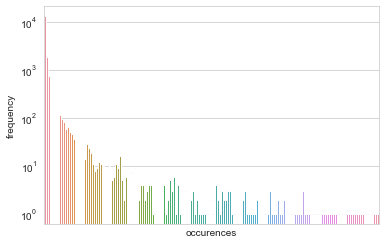

In [60]:
freq_df = terms.value_counts().value_counts().to_frame().reset_index()\
    .rename(columns = {'index' : 'occurences', 'disease_tags' : 'frequency'})

ax = seaborn.barplot(data = freq_df, x= 'occurences', y = 'frequency')
ax.set_yscale('log')
ax.set_xticks([])

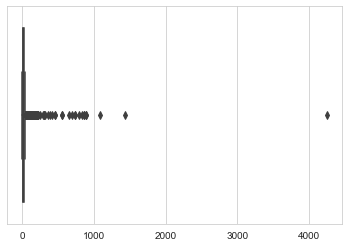

In [81]:
counts = terms.value_counts()
seaborn.boxplot(counts[counts > 5].values)

In [97]:
counts[0:500].to_frame().reset_index().rename(columns = {'index' : 'disease', 'disease_tags' : 'freq'})\
    .to_csv(os.path.join(data_dir, 'disease_terms.csv'), index = False, header = True)

In [168]:
def cycle(node1, node2):
    return (node1, node2), (node2, node1)

edges = [
    ('disease', 'infectious diseases'),
    ('disease', 'virus diseases'),
    ('infectious diseases', 'infection'),
    ('infection', 'virus infection'),
    *cycle('infection','infections'),
    ('symptoms','inflammation'),
    ('virus infection', 'respiratory infections'),
    ('respiratory infections', 'bronchitis'),
    ('coronavirus','coronavirus symptoms'),
    ('coronavirus symptoms', 'fever'),
    ('coronavirus symptoms', 'sore throat'),
    ('coronavirus symptoms', 'pneumonia'),
    ('coronavirus symptoms', 'cough'),
    ('respiratory infections', 'measles'),
    ('fever', 'encephalitis'),
    ('respiratory infections', 'inflammation'),
    ('respiratory infections', 'respiratory tract infections'),
    ('respiratory syndrome', 'acute respiratory syndrome'),   
    ('respiratory syndrome', 'MERS'),
    ('respiratory syndrome', 'severe acute respiratory syndrome'),
    ('respiratory syndrome', 'respiratory syndrome coronavirus'),
    *cycle('severe acute respiratory syndrome', 'SARS'),
    ('respiratory infections', 'H1N1'),
    ('respiratory infections', 'respiratory syndrome'),
    ('respiratory infections', 'throat'),
    ('noninfectious disease', 'cancer'),
    ('cancer', 'tumor'),
    *cycle('MERS', 'MERS-CoV infection'),
    *cycle('MERS', 'Middle East respiratory syndrome'),
    ('coronavirus', 'MERS'),
    ('coronavirus', 'H1N1'),
    ('coronavirus', 'SARS'),
    ('coronavirus', 'COVID-19'),
    ('symptoms','wheezing'),
    ('risk factors', 'cancer'),
    ('risk factors', 'diabetes'),
    ('risk factors', 'immunocompromised'),
    ('risk factors', 'obesity'),
    *cycle('obesity','Obesity'),
    ('immunocompromised', 'human immunodeficiency virus (HIV)'),
    *cycle('human immunodeficiency virus (HIV)','HIV'),
    *cycle('immunocompromised', 'immunodeficiency'),
    ('infectious diseases', 'Ebola'),
    ('Ebola', 'Ebola virus'),
    *cycle('Ebola virus', 'Ebola virus infection'),
    ('infectious diseases', 'zoonotic disease'),
    ('zoonotic disease','SARS'),
    ('zoonotic disease','MERS'),
    ('zoonotic disease','COVID-19'),
    ('SARS', 'SARS-CoV infection'),
    ('SARS', 'SARS-CoV'),
    ('lung infection', 'bronchitis'),
    ('lung infection', 'bronchiolitis'),
    ('lung infection', 'pneumonia'),
    ('respiratory infection', 'lung infection'),
    ('coronavirus', 'influenza'),
    ('infection','influenza-like illness'),
    ('respiratory syndrome', 'respiratory syndrome virus'),
    ('virus infection', 'hepatitis'),
    ('hepatitis', 'hepatitis C'),
    ('hepatitis', 'hepatitis B'),
    ('virus diseases', 'hepatitis'),
    ('virus infection', 'gastroenteritis'),
    ('gastroenteritis', 'gastroenteritis virus'),
    ('gastroenteritis', 'enterovirus'),
    ('respiratory infections', 'pneumonia'),
    ('pneaumonia', 'Streptococcus pneumoniae'),
    ('noninfectious disease', 'diabetes'),
    *cycle('influenza', 'influenza infection'),
    ('symptoms', 'cough'),
    ('symptoms', 'fever'),
    ('symptoms', 'throat'),
    ('symptoms', 'sepsis'),
    ('respiratory infection', 'respiratory failure'),
    ('infection', 'bacterial infection'),
    ('bacterial infection', 'pneumonia'),
    ('hepatitis','hepatitis A'),
    ('infectious diseases','human immunodeficiency virus'),
    *cycle('human immunodeficiency virus','HIV infection'),
    *cycle('human immunodeficiency virus', 'human immunodeficiency virus (HIV)'),
    ('symptoms', 'sore throat'),
    ('pneumonia','viral pneumonia'),
    *cycle('HIV infection','human immunodeficiency virus (HIV)'),
    ('symptoms', 'viral diarrhea'),
    ('HIV infection','AIDS'),
    *cycle('COVID-19','coronavirus disease 2019'),
    ('bloodborne pathogen', 'Ebola'),
    ('bloodborne pathogen','Malaria'),
    ('disease','bloodborne pathogen'),
    ('infection','symptoms'),
    ('symptoms','vomiting'),
    *cycle('virus diseases','viral disease'),
    *cycle('tumor','tumors'),
    ('respiratory infection','acute respiratory infection'),
    ('immunocompromised','autoimmune diseases'),
    *cycle('fever','Fever'),
    *cycle('MERS','Middle East Respiratory Syndrome'),
    ('infectious diseases','tuberculosis'),
    ('tuberculosis','Mycobacterium tuberculosis'),
    ('sepsis','shock'),
    ('lung infection','lung injury'),
    ('symptoms','pain'),
    ('symptoms','headache'),
    *cycle('encephalitis', 'neuroinflammation'),
    ('influenza', 'influenza B'),
    ('influenza', 'influenza A'),
    *cycle('influenza A','influenza A virus'),
    ('influenza','H1N1'),
    *cycle('H1N1','H1N1 influenza'),
    ('cancer','breast cancer'),
    ('risk factors', 'liver disease'),
    *cycle('sepsis', 'septic shock'),
]

term_hierarchy = nx.DiGraph()
term_hierarchy.add_edges_from(edges)

In [169]:
with open(os.path.join(data_dir, 'topic_graph.json'), 'w') as f:
    f.write(json.dumps(edges, indent = 4))

[Top](#toc)
<a name="paragraph8"></a>
# 9. Clean Data for Dashboarding

In [2]:
data = pd.read_csv(os.path.join(data_dir, 'metadata_analysis_complete.csv'))
data = data.drop(columns = {'Unnamed: 0'})

In [3]:
from datetime import datetime
import time

In [4]:
def get_timestamp(unformatted_date):
    try:
        return str(datetime.strptime(unformatted_date, '%d %B %Y'))
    except ValueError:
        pass
    
    try:
        return str(datetime.strptime(unformatted_date, '%d %b %Y'))
    except ValueError:
        pass

    try:
        return str(datetime.strptime(unformatted_date, '%m/%d/%Y'))
    except ValueError:
        pass
    
    try:
        return str(datetime.strptime(unformatted_date, '%Y-%m-%d'))
    except ValueError:
        pass
    
    try:
        return str(datetime.strptime(unformatted_date, '%Y %b %d'))
    except ValueError:
        pass
    
    try:
        return str(datetime.strptime(unformatted_date, '%Y %b %d'))
    except ValueError:
        pass
    
    try:
        return str(datetime.strptime(unformatted_date, '%Y %b'))
    except ValueError:
        pass
    
    return 'unknown'

In [5]:
data['published_timestamp'] = data['publish_time'].apply(lambda x : get_timestamp(x))

In [7]:
data[data['published_timestamp'] == 'unknown']['publish_time']

101             2015 Jul-Sep
190       2012 Jun 1 Jan-Mar
226             2018 Sep-Oct
266       2009 Sep 1 Jul-Sep
458      2019 Feb 20 Mar-Apr
                ...         
24373           2018 Oct-Dec
24402           2014 Jul-Sep
24418           2017 Oct-Dec
24434           2012 Apr-Jun
24560           2010 Jan-Mar
Name: publish_time, Length: 190, dtype: object

In [9]:
def pretty_date(row_data):
    
    date_str = row_data['published_timestamp']
    if date_str == 'unknown':
        return row_data['year']
    else:
        date_obj = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
        return date_obj.strftime('%Y %b %d')
    
data['pretty_date'] = data.apply(lambda x : pretty_date(x), axis = 1)

In [10]:
year_timestamp = data['year'].apply(lambda x : str(datetime.strptime(str(x), '%Y')))
year_timestamp

0        2020-01-01 00:00:00
1        2019-01-01 00:00:00
2        2018-01-01 00:00:00
3        2003-01-01 00:00:00
4        2009-01-01 00:00:00
                ...         
24663    2020-01-01 00:00:00
24664    2020-01-01 00:00:00
24665    2019-01-01 00:00:00
24666    1994-01-01 00:00:00
24667    2010-01-01 00:00:00
Name: year, Length: 24668, dtype: object

In [11]:
data['published_timestamp'].where(data['published_timestamp'] != 'unknown', year_timestamp, inplace= True)

In [12]:
data.published_timestamp[data.published_timestamp == 'unknown'].sum()

0

In [14]:
data = data.dropna(subset = ['title','abstract','published_timestamp','label','pagerank','docvec'])

In [19]:
data.columns

Index(['id', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_full_text',
       'full_text_file', 'year', 'first_author', 'docvec', 'label', 'pagerank',
       'disease_tags', 'category_description', 'published_timestamp',
       'pretty_date'],
      dtype='object')

In [21]:
data.to_csv(os.path.join(data_dir, 'dash_data.csv'), index = False, header = True)